In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


## 1. Import libraries and Version Check

Purpose: Import necessary libraries and print the versions of TensorFlow and TensorFlow Decision Forests.

In [2]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("TensorFlow version:", tf.__version__)
print("TensorFlow Decision Forests version:", tfdf.__version__)


2024-06-02 12:13:15.818925: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 12:13:15.819056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 12:13:15.963666: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0
TensorFlow Decision Forests version: 1.8.1


## 2. Load and Inspect Dataset
Purpose: Load the dataset and display its initial shape.

In [3]:
dataset_path = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
dataset = pd.read_csv(dataset_path)
print("Initial dataset shape:", dataset.shape)


Initial dataset shape: (1460, 81)


## 3. Drop Unwanted Columns
Purpose: Remove the 'Id' column which is not needed for model training.

In [4]:
dataset = dataset.drop(['Id'], axis=1)
print("Dataset shape after dropping 'Id':", dataset.shape)


Dataset shape after dropping 'Id': (1460, 80)


## 4. Basic Dataset Info
Purpose: Display information about the dataset, including column types and statistics for the 'SalePrice' column.

In [5]:
dataset.info()
print("\nSalePrice statistics:")
print(dataset['SalePrice'].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## 5. Data Visualization
Purpose: Plot the distribution of 'SalePrice' to visualize how sale prices are spread out.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


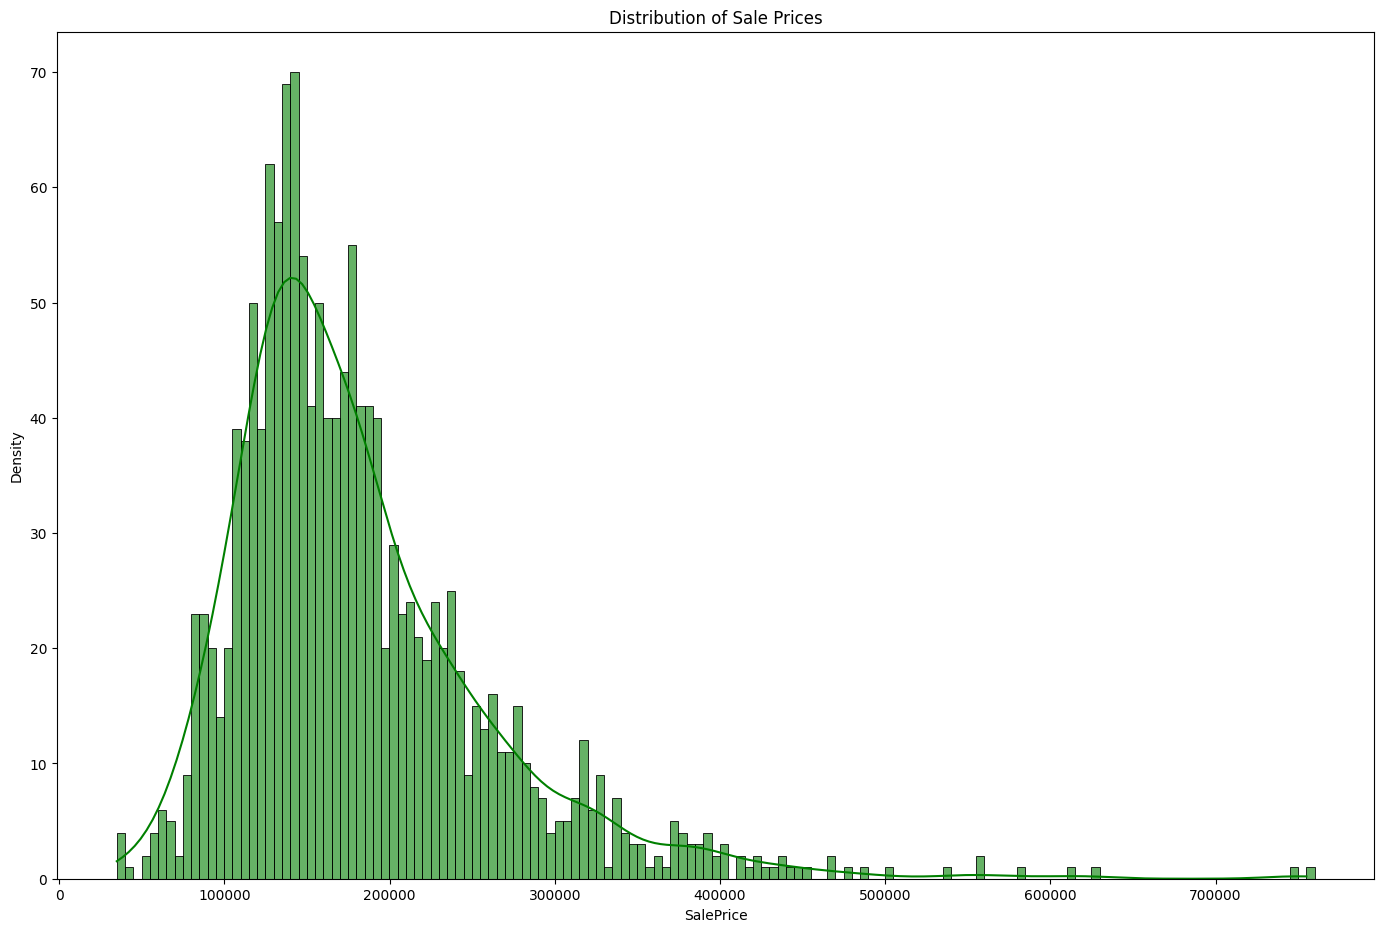

In [6]:
plt.figure(figsize=(17, 11))
sns.histplot(dataset['SalePrice'], color='g', bins=100, alpha=0.6, binwidth=5000, kde=True)
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Distribution of Sale Prices')
plt.show()


## 6. Select Numeric Columns
Purpose: Select only numeric columns from the dataset for further analysis.

In [7]:
dataset_num = dataset.select_dtypes(include=['float64', 'int64'])
dataset_num.head()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


## 7. Plot Histograms for Numeric Columns
Purpose: Plot histograms for all numeric columns to understand their distributions.

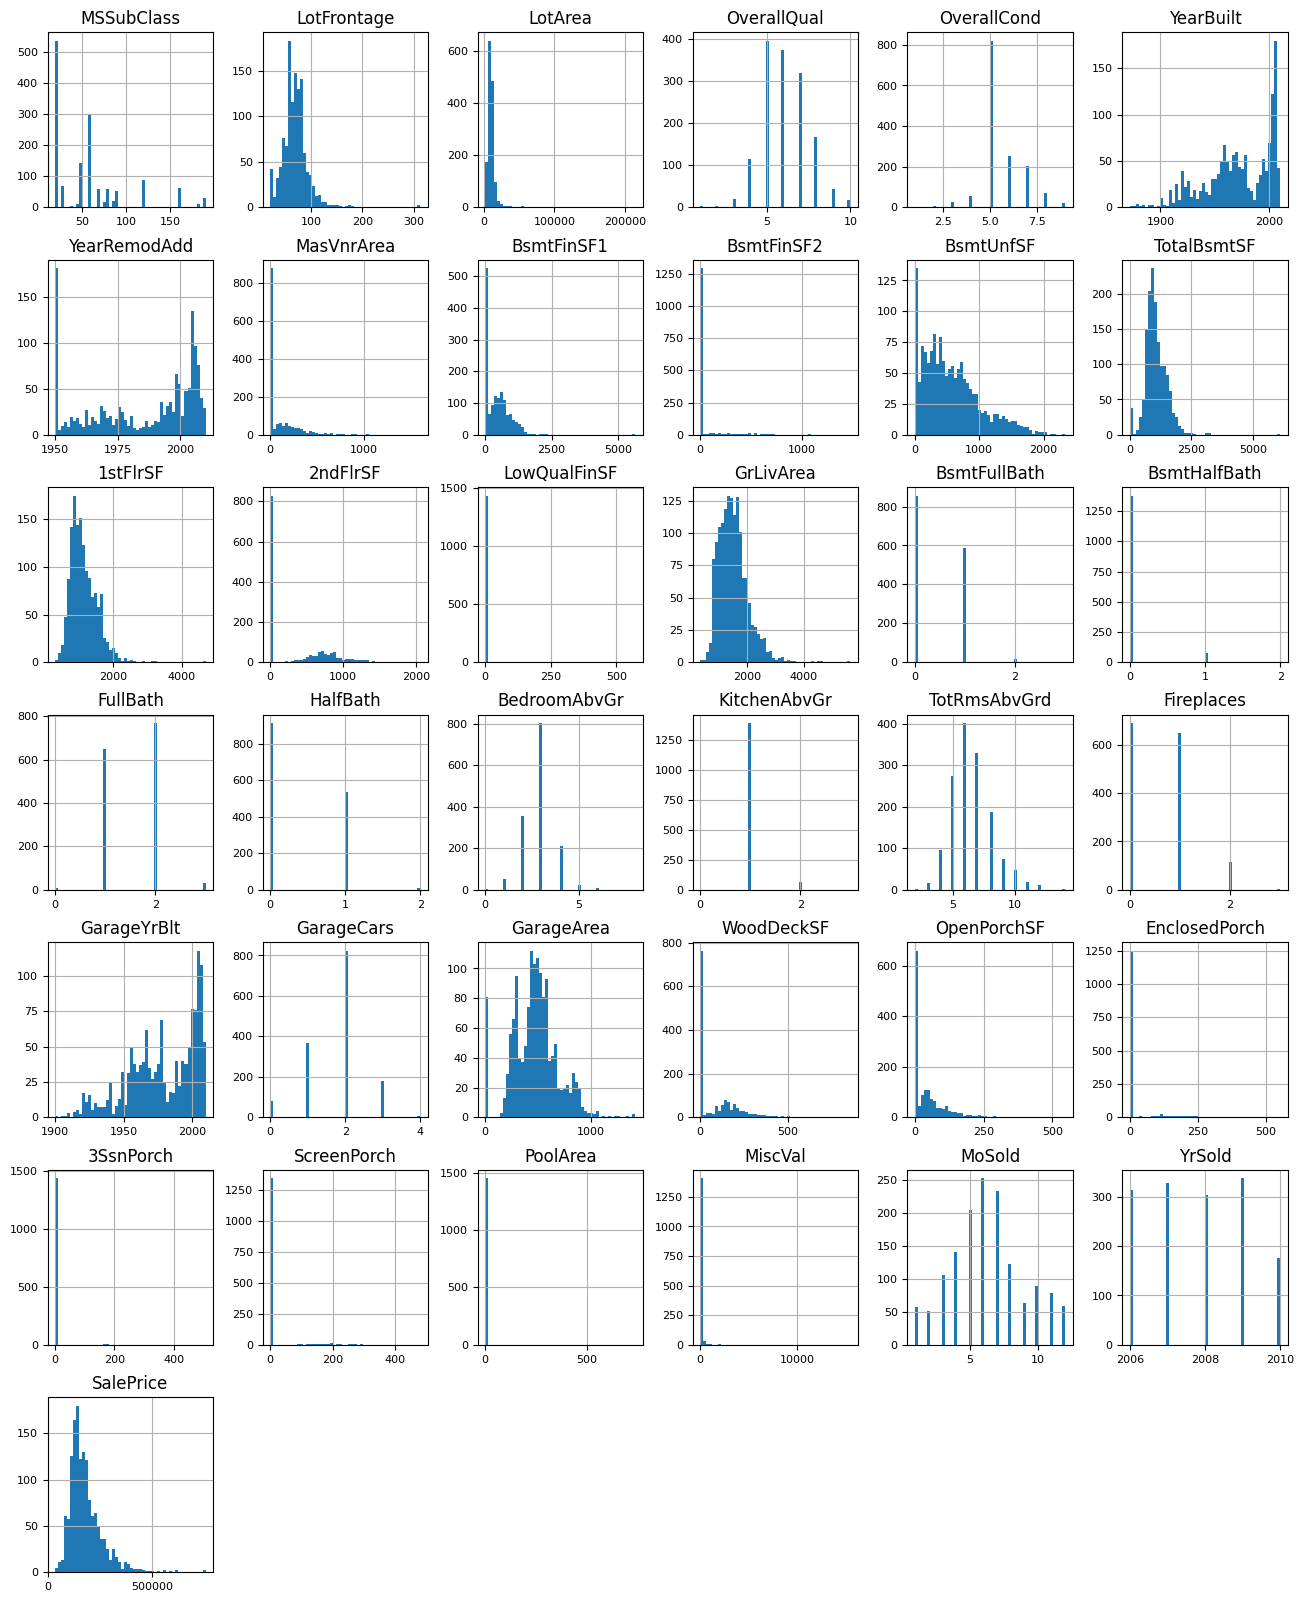

In [8]:
dataset_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()


## 8. Dataset Splitting Function
Purpose: Define a function to split the dataset into training and testing sets, then split and print the sizes of each set.

In [9]:
def split_dataset(dataset, test_ratio=0.30):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset)
print(f"{len(train_ds_pd)} examples in training, {len(valid_ds_pd)} examples in testing.")


1055 examples in training, 405 examples in testing.


## 9. Convert to TensorFlow Dataset

In [10]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)


## 10. Model Initialization and Training
Purpose: Initialize, compile, and train the RandomForest model using the training dataset.

In [11]:
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model.compile(metrics=["mse"])
model.fit(train_ds)


Use /tmp/tmpjcnv8keh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:05.978170. Found 1055 examples.
Training model...


[INFO 24-06-02 12:13:45.8918 UTC kernel.cc:1233] Loading model from path /tmp/tmpjcnv8keh/model/ with prefix 4c33c3d3bb3447bf


Model trained in 0:00:02.056240
Compiling model...


[INFO 24-06-02 12:13:46.2580 UTC decision_forest.cc:660] Model loaded with 300 root(s), 100384 node(s), and 73 input feature(s).
[INFO 24-06-02 12:13:46.2581 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-06-02 12:13:46.2581 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


## 11. Model Evaluation

In [12]:
inspector = model.make_inspector()
print("\nModel Evaluation:")
print(inspector.evaluation())

evaluation = model.evaluate(x=valid_ds, return_dict=True)
print("\nValidation Performance:")
for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")



Model Evaluation:
Evaluation(num_examples=1055, accuracy=None, loss=None, rmse=29389.041163513928, ndcg=None, aucs=None, auuc=None, qini=None)
1/1 [==============================] - 6s 6s/step - loss: 0.0000e+00 - mse: 1173813248.0000

Validation Performance:
loss: 0.0000
mse: 1173813248.0000


## 12. Variable Importances
Purpose: Display and print the variable importances for the 'NUM_AS_ROOT' metric.

In [13]:
print("\nAvailable variable importances:")
for importance in inspector.variable_importances().keys():
    print("\t", importance)

variable_importances = inspector.variable_importances()["NUM_AS_ROOT"]
print("\nVariable importances for NUM_AS_ROOT:")
for feature, importance in variable_importances:
    print(f"{feature}: {importance}")



Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES

Variable importances for NUM_AS_ROOT:
"OverallQual" (1; #62): 108.0
"ExterQual" (4; #22): 68.0
"Neighborhood" (4; #59): 29.0
"GarageCars" (1; #32): 25.0
"GrLivArea" (1; #38): 17.0
"YearBuilt" (1; #76): 15.0
"BsmtQual" (4; #14): 11.0
"KitchenQual" (4; #44): 11.0
"TotalBsmtSF" (1; #73): 8.0
"1stFlrSF" (1; #0): 4.0
"GarageArea" (1; #31): 2.0
"Foundation" (4; #28): 1.0
"FullBath" (1; #29): 1.0


## 13. Plot Variable Importances
Purpose: Plot the variable importances for the 'NUM_AS_ROOT' metric to visualize which features are most important.

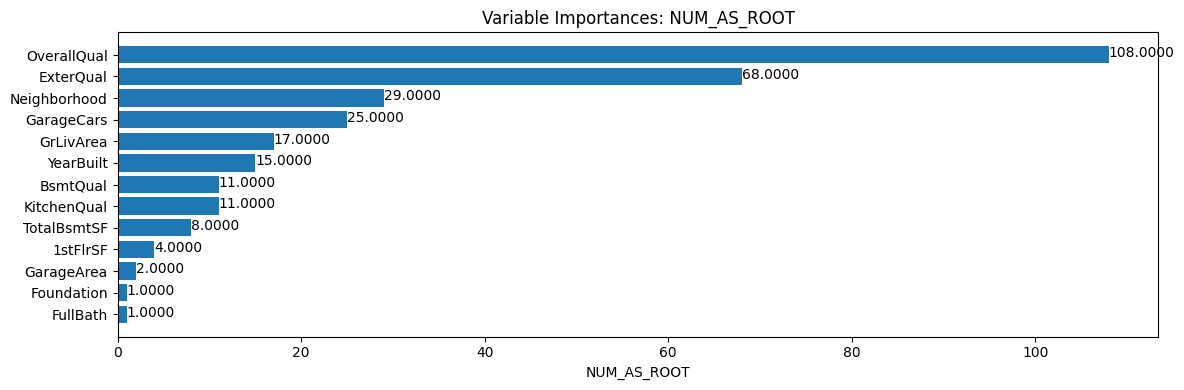

In [14]:
plt.figure(figsize=(12, 4))
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
feature_ranks = range(len(feature_names))
bar = plt.barh(feature_ranks, feature_importances)
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()
for importance, patch in zip(feature_importances, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")
plt.xlabel("NUM_AS_ROOT")
plt.title("Variable Importances: NUM_AS_ROOT")
plt.tight_layout()
plt.show()


## 14. Predict and Create Submission File

In [15]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('Id')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, task=tfdf.keras.Task.REGRESSION)
preds = model.predict(test_ds)

output = pd.DataFrame({'Id': ids, 'SalePrice': preds.squeeze()})
print("\nSample submission:")
print(output.head())

sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = preds.squeeze()
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
print("\nFinal submission:")
print(sample_submission_df.head())


2/2 [==============================] - 1s 23ms/step

Sample submission:
     Id      SalePrice
0  1461  122859.960938
1  1462  152393.359375
2  1463  176324.765625
3  1464  181994.859375
4  1465  196658.156250

Final submission:
     Id      SalePrice
0  1461  122859.960938
1  1462  152393.359375
2  1463  176324.765625
3  1464  181994.859375
4  1465  196658.156250
